In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.python.keras.models import Sequential, load_model
from tensorflow.python.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.python.keras.layers import SimpleRNN, LSTM
from tensorflow.python.keras.preprocessing.sequence import pad_sequences

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import glob
import matplotlib as mpl
import matplotlib.pyplot as plt

In [3]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i)
    # Reshape data from (history_size,) to (history_size, 1)
    data.append(np.reshape(dataset[indices], (history_size, 1)))
    labels.append(dataset[i+target_size])
  return np.array(data), np.array(labels)

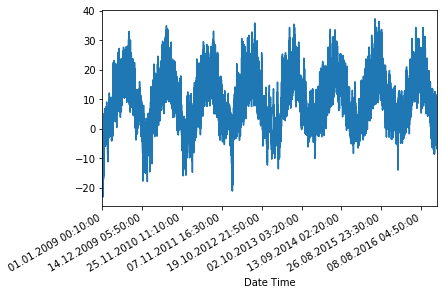

In [4]:
df = pd.read_csv("jena_climate_2009_2016.csv")

df.head()

TRAIN_SPLIT = 300000

uni_data = df['T (degC)']
uni_data.index = df['Date Time']
uni_data.plot(subplots=True)
uni_data = uni_data.values

In [5]:
ut_mean = uni_data[:TRAIN_SPLIT].mean()
ut_std = uni_data[:TRAIN_SPLIT].std()

uni_data = (uni_data - ut_mean) / ut_std

In [6]:
univariate_past_history = 20
univariate_future_target = 0

x_train_uni, y_train_uni = univariate_data(uni_data, 0, TRAIN_SPLIT,
                                           univariate_past_history,
                                           univariate_future_target)
x_val_uni, y_val_uni = univariate_data(uni_data, TRAIN_SPLIT, None,
                                       univariate_past_history,
                                       univariate_future_target)

In [7]:
def create_time_steps(length):
  return list(range(-length, 0))

def baseline(history):
  return np.mean(history)

In [8]:
def show_plot(plot_data, delta, title):
  labels = ['History', 'True Future', 'Model Prediction']
  marker = ['.-', 'rx', 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])
  if delta:
    future = delta
  else:
    future = 0

  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('Time-Step')
  return plt

In [9]:
print(x_train_uni.shape)
print(y_train_uni.shape[0])

(299980, 20, 1)
299980


<module 'matplotlib.pyplot' from '/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/matplotlib/pyplot.py'>

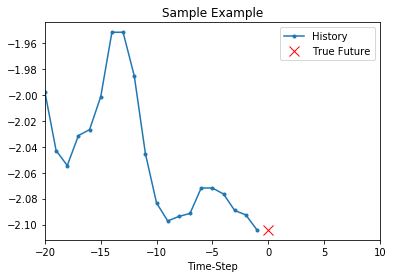

In [10]:
show_plot([x_train_uni[0], y_train_uni[0]], 0, 'Sample Example')

<module 'matplotlib.pyplot' from '/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/matplotlib/pyplot.py'>

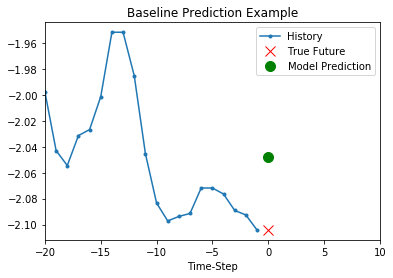

In [11]:
show_plot([x_train_uni[0], y_train_uni[0], baseline(x_train_uni[0])], 0,
           'Baseline Prediction Example')

In [13]:
BATCH_SIZE = 256
BUFFER_SIZE = 10000

In [14]:
train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

In [15]:
simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(8, input_shape=x_train_uni.shape[-2:]),
    tf.keras.layers.Dense(1)
])

simple_lstm_model.compile(optimizer='adam', loss='mae')

In [16]:
for x, y in val_univariate.take(1):
    print(simple_lstm_model.predict(x).shape)

(256, 1)


In [17]:
for x, y in val_univariate.take(3):
    print(val_univariate)
    print(x.numpy().shape)
    print(y.numpy().shape)

<RepeatDataset shapes: ((None, 20, 1), (None,)), types: (tf.float64, tf.float64)>
(256, 20, 1)
(256,)
<RepeatDataset shapes: ((None, 20, 1), (None,)), types: (tf.float64, tf.float64)>
(256, 20, 1)
(256,)
<RepeatDataset shapes: ((None, 20, 1), (None,)), types: (tf.float64, tf.float64)>
(256, 20, 1)
(256,)


In [18]:
EVALUATION_INTERVAL = 200
EPOCHS = 10

simple_lstm_model.fit(train_univariate, epochs=EPOCHS,
                      steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=val_univariate, validation_steps=50)

Train for 200 steps, validate for 50 steps
Epoch 1/10
200/200 [==============================] - 6s 28ms/step - loss: 0.3999 - val_loss: 0.0757
Epoch 2/10
200/200 [==============================] - 3s 14ms/step - loss: 0.0980 - val_loss: 0.0398
Epoch 3/10
200/200 [==============================] - 3s 14ms/step - loss: 0.0519 - val_loss: 0.0285
Epoch 4/10
200/200 [==============================] - 3s 14ms/step - loss: 0.0422 - val_loss: 0.0248
Epoch 5/10
200/200 [==============================] - 3s 15ms/step - loss: 0.0286 - val_loss: 0.0230
Epoch 6/10
200/200 [==============================] - 3s 16ms/step - loss: 0.0308 - val_loss: 0.0219
Epoch 7/10
200/200 [==============================] - 3s 15ms/step - loss: 0.0279 - val_loss: 0.0212
Epoch 8/10
200/200 [==============================] - 3s 13ms/step - loss: 0.0260 - val_loss: 0.0196
Epoch 9/10
200/200 [==============================] - 3s 14ms/step - loss: 0.0252 - val_loss: 0.0187
Epoch 10/10
200/200 [===========================

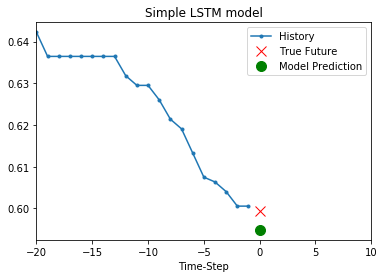

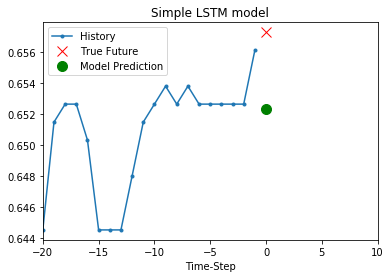

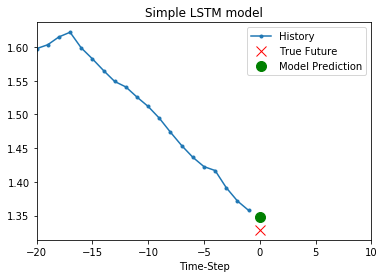

In [19]:
for x, y in val_univariate.take(3):
  plot = show_plot([x[0].numpy(), y[0].numpy(),
                    simple_lstm_model.predict(x)[0]], 0, 'Simple LSTM model')
  plot.show()

# MULTIVARITE

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f8e482102d0>,
      dtype=object)

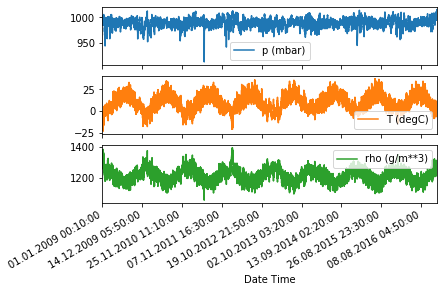

In [20]:
features_considered = ['p (mbar)', 'T (degC)', 'rho (g/m**3)']
features = df[features_considered]
features.index = df['Date Time']
features.head()
features.plot(subplots = True)

In [21]:
dataset = features.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)

dataset = (dataset-data_mean)/data_std

In [22]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i, step)
    data.append(dataset[indices])

    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])

  return np.array(data), np.array(labels)

In [23]:
past_history = 720
future_target = 72
STEP = 6

x_train_single, y_train_single = multivariate_data(dataset, dataset[:, 1], 0,
                                                   TRAIN_SPLIT, past_history,
                                                   future_target, STEP,
                                                   single_step=True)
x_val_single, y_val_single = multivariate_data(dataset, dataset[:, 1],
                                               TRAIN_SPLIT, None, past_history,
                                               future_target, STEP,
                                               single_step=True)

In [24]:
print ('Single window of past history : {}'.format(x_train_single[0].shape))

Single window of past history : (120, 3)


In [107]:
train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single))
train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_single = tf.data.Dataset.from_tensor_slices((x_val_single, y_val_single))
val_data_single = val_data_single.batch(BATCH_SIZE).repeat()

In [108]:
single_step_model = tf.keras.models.Sequential()
single_step_model.add(tf.keras.layers.LSTM(32,
                                           input_shape=x_train_single.shape[-2:]))
single_step_model.add(tf.keras.layers.Dense(1))

single_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae')

In [109]:
single_step_history = single_step_model.fit(train_data_single, epochs=EPOCHS,
                                            steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data=val_data_single,
                                            validation_steps=50)

Train for 200 steps, validate for 50 steps
Epoch 1/10
200/200 [==============================] - 26s 128ms/step - loss: 0.3169 - val_loss: 0.2523
Epoch 2/10
200/200 [==============================] - 22s 109ms/step - loss: 0.2618 - val_loss: 0.2461
Epoch 3/10
200/200 [==============================] - 22s 110ms/step - loss: 0.2598 - val_loss: 0.2442
Epoch 4/10
200/200 [==============================] - 23s 114ms/step - loss: 0.2578 - val_loss: 0.2367
Epoch 5/10
200/200 [==============================] - 22s 108ms/step - loss: 0.2285 - val_loss: 0.2315
Epoch 6/10
200/200 [==============================] - 21s 104ms/step - loss: 0.2402 - val_loss: 0.2586
Epoch 7/10
200/200 [==============================] - 22s 109ms/step - loss: 0.2442 - val_loss: 0.2497
Epoch 8/10
200/200 [==============================] - 22s 109ms/step - loss: 0.2402 - val_loss: 0.2393
Epoch 9/10
200/200 [==============================] - 21s 107ms/step - loss: 0.2442 - val_loss: 0.2501
Epoch 10/10
200/200 [=========

In [110]:
def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title(title)
  plt.legend()

  plt.show()

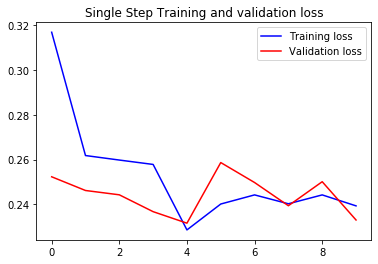

In [111]:
plot_train_history(single_step_history,
                   'Single Step Training and validation loss')

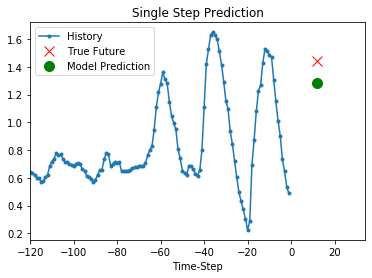

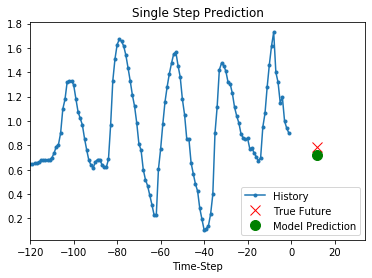

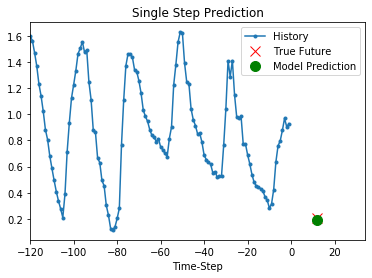

In [112]:
for x, y in val_data_single.take(3):
  plot = show_plot([x[0][:, 1].numpy(), y[0].numpy(),
                    single_step_model.predict(x)[0]], 12,
                   'Single Step Prediction')
  plot.show()

# MULTISTEP

In [25]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i, step)
    data.append(dataset[indices])

    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])

  return np.array(data), np.array(labels)

In [26]:
future_target = 72
x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, 1], 0,
                                                 TRAIN_SPLIT, past_history,
                                                 future_target, STEP)
x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, 1],
                                             TRAIN_SPLIT, None, past_history,
                                             future_target, STEP)

In [27]:
print ('Single window of past history : {}'.format(x_train_multi[0].shape))
print ('\n Target temperature to predict : {}'.format(y_train_multi[0].shape))

Single window of past history : (120, 3)

 Target temperature to predict : (72,)


In [29]:
print(dataset.shape)
print(x_train_multi.shape)

(420551, 3)
(299280, 120, 3)


In [115]:
train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

In [124]:
def multi_step_plot(history, true_future, prediction):
  plt.figure(figsize=(12, 6))
  num_in = create_time_steps(len(history))
  num_out = len(true_future)

  plt.plot(num_in, np.array(history[:, 1]), label='History')
  plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
           label='True Future')
  if prediction.any():
    plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
             label='Predicted Future')
  plt.legend(loc='upper left')
  plt.show()

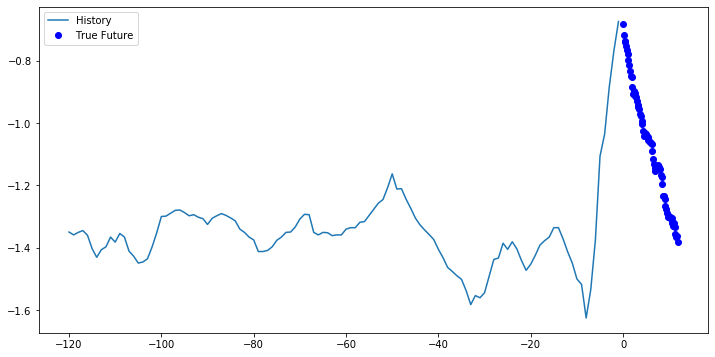

In [125]:
for x, y in train_data_multi.take(1):
  multi_step_plot(x[0], y[0], np.array([0]))

In [126]:
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(32,
                                          return_sequences=True,
                                          input_shape=x_train_multi.shape[-2:]))
multi_step_model.add(tf.keras.layers.LSTM(16, activation='relu'))
multi_step_model.add(tf.keras.layers.Dense(72))

multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')

In [131]:
for x, y in val_data_multi.take(3):
  print (multi_step_model.predict(x).shape)

(256, 72)
(256, 72)
(256, 72)


In [128]:
multi_step_history = multi_step_model.fit(train_data_multi, epochs=EPOCHS,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=val_data_multi,
                                          validation_steps=50)

Train for 200 steps, validate for 50 steps
Epoch 1/10
200/200 [==============================] - 47s 236ms/step - loss: 0.6321 - val_loss: 0.3667
Epoch 2/10
200/200 [==============================] - 43s 214ms/step - loss: 2.1406 - val_loss: 0.2972
Epoch 3/10
200/200 [==============================] - 42s 208ms/step - loss: 0.4068 - val_loss: 0.3209
Epoch 4/10
200/200 [==============================] - 41s 206ms/step - loss: 0.3648 - val_loss: 0.2784
Epoch 5/10
200/200 [==============================] - 41s 205ms/step - loss: 0.2755 - val_loss: 0.2278
Epoch 6/10
200/200 [==============================] - 41s 207ms/step - loss: 0.2319 - val_loss: 0.2353
Epoch 7/10
200/200 [==============================] - 39s 197ms/step - loss: 0.2144 - val_loss: 0.2314
Epoch 8/10
200/200 [==============================] - 41s 203ms/step - loss: 0.2060 - val_loss: 0.2055
Epoch 9/10
200/200 [==============================] - 33s 164ms/step - loss: 0.2093 - val_loss: 0.1881
Epoch 10/10
200/200 [=========

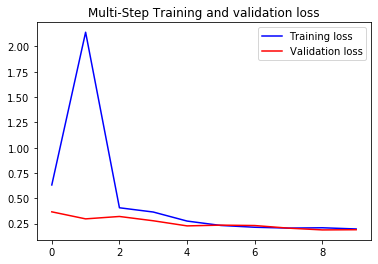

In [129]:
plot_train_history(multi_step_history, 'Multi-Step Training and validation loss')

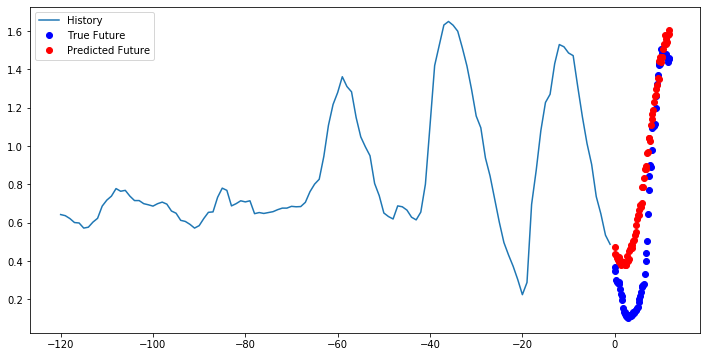

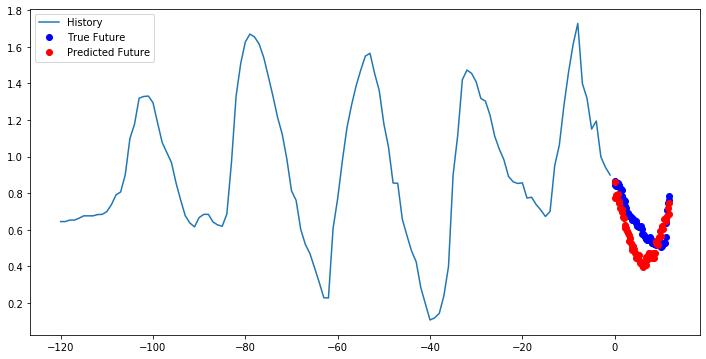

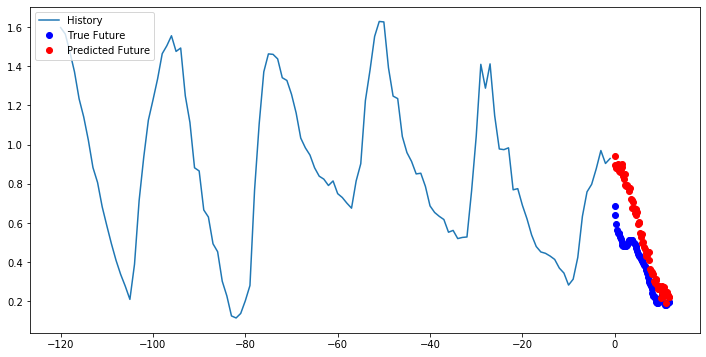

In [130]:
for x, y in val_data_multi.take(3):
  multi_step_plot(x[0], y[0], multi_step_model.predict(x)[0])